<a href="https://colab.research.google.com/github/CristianRiquelmeF/Ciencia-de-datos/blob/main/Trabajo4/XGBoost_desaf%C3%ADo_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Presentación del proyecto y la data**

Se presenta un proyecto de Machine Learning que tiene como objetivo trabajar con un conjunto de datos que contiene información detallada sobre diferentes tipos de viviendas. Este conjunto de datos incluye una amplia variedad de características, como las cualidades habitacionales, la relación con el entorno, los metros cuadrados de sótanos, el primer y segundo piso (considerando cada ocasión pertinente), el garaje y su capacidad de autos, el año de construcción, entre otros.

Cada una de estas variables desempeña un papel fundamental en la evaluación del costo de una vivienda y está incluida en los datos. En total, el conjunto de datos consta de 38 variables numéricas y 43 variables categóricas que se utilizarán para llevar a cabo el análisis y la predicción de los precios de las viviendas.


Este es un desafío bastante común para aplicar en la plataforma Kaggle, por lo que al final se guardarán los resultados para evaluar el rendimiento del modelo de Machine Learning seleccionado después del análisis.






In [ ]:
# Carga de librerías

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.stats import norm, skew
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Carga de datos.

train = pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/train.csv')
test = pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/test.csv')
sample = pd.read_csv('/content/drive/MyDrive/House Prices - Advanced Regression Techniques/sample_submission.csv')

In [ ]:
train.shape , test.shape

((1460, 81), (1459, 80))

In [ ]:
# Exploración de la data 'train'.

l=list()
for v in train.columns:
  d=dict()
  d['var']=v
  d['cardinalidad']=len(train[v].unique())
  d['tipo']=train[v].dtype
  d['nulos']=len(train[train[v].isna()])
  if d['tipo']!='object':
    d['mean']=train[v].mean()
    d['max']=train[v].max()
    d['min']=train[v].min()
    d['zeros']=len(train[train[v]==0])/len(train)
  d['ejemplo']=','.join([str(x) for x in random.choices(train[v].unique().tolist(), k=4)])
  l.append(d)
tabla_variables=pd.DataFrame(l)
tabla_variables

,var,cardinalidad,tipo,nulos,mean,max,min,zeros,ejemplo
0,Id,1460,int64,0,730.500000,1460.0,1.0,0.0,"294,479,850,213"
1,MSSubClass,15,int64,0,56.897260,190.0,20.0,0.0,"90,160,20,45"
2,MSZoning,5,object,0,NaN,NaN,NaN,NaN,"RM,RM,RL,RL"
3,LotFrontage,111,float64,259,70.049958,313.0,21.0,0.0,"48.0,168.0,77.0,79.0"
4,LotArea,1073,int64,0,10516.828082,215245.0,1300.0,0.0,"9765,11362,11184,57200"
...,...,...,...,...,...,...,...,...,...
76,MoSold,12,int64,0,6.321918,12.0,1.0,0.0,"5,8,4,11"
77,YrSold,5,int64,0,2007.815753,2010.0,2006.0,0.0,"2009,2010,2009,2010"
78,SaleType,9,object,0,NaN,NaN,NaN,NaN,"ConLI,ConLD,COD,ConLw"
79,SaleCondition,6,object,0,NaN,NaN,NaN,NaN,"Partial,AdjLand,Partial,Abnorml"


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.882876
Kurtosis: 6.536282


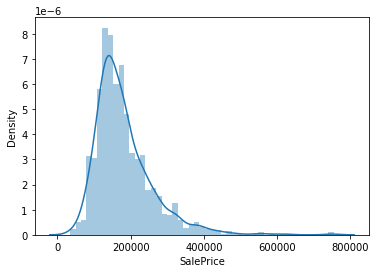

In [ ]:
# Gráfica de la distribución de la varibale dependiente del modelo 'SalePrice'.
sns.distplot(train['SalePrice']);
# skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 0.121347
Kurtosis: 0.809519


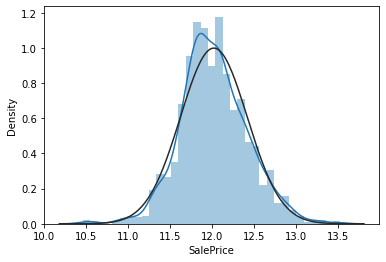

In [ ]:
# La variable no posee distribución normal, asimetría positiva, por lo que se aplica función logarítmica para normalizar.
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'], fit=norm)

# skewness y kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())


In [ ]:
# Conteo variables numéricas y no numéricas.

numeric_columns = train.select_dtypes(include=['int64','float64'])
nc = len(numeric_columns.columns)
non_numeric_columns = len(train.columns) - nc
print("numeric columns : " , nc ,"\n","Not numeric columns : ",non_numeric_columns)

numeric columns :  38 
 Not numeric columns :  43


In [ ]:
l=list()
for v in numeric_columns.columns:
  d=dict()
  d['var']=v
  d['cardinalidad']=len(numeric_columns[v].unique())
  d['tipo']=numeric_columns[v].dtype
  d['nulos']=len(numeric_columns[numeric_columns[v].isna()])
  if d['tipo']!='object':
    d['mean']=numeric_columns[v].mean()
    d['max']=numeric_columns[v].max()
    d['min']=numeric_columns[v].min()
    d['zeros']=len(numeric_columns[numeric_columns[v]==0])/len(numeric_columns)
  d['ejemplo']=','.join([str(x) for x in random.choices(numeric_columns[v].unique().tolist(), k=4)])
  l.append(d)
tabla_variablesnum=pd.DataFrame(l)
tabla_variablesnum

,var,cardinalidad,tipo,nulos,mean,max,min,zeros,ejemplo
0,Id,1460,int64,0,730.500000,1460.000000,1.000000,0.000000,"1153,364,1233,361"
1,MSSubClass,15,int64,0,56.897260,190.000000,20.000000,0.000000,"60,180,60,45"
2,LotFrontage,111,float64,259,70.049958,313.000000,21.000000,0.000000,"82.0,100.0,110.0,108.0"
3,LotArea,1073,int64,0,10516.828082,215245.000000,1300.000000,0.000000,"11846,8125,11616,12416"
4,OverallQual,10,int64,0,6.099315,10.000000,1.000000,0.000000,"8,6,8,10"
5,OverallCond,9,int64,0,5.575342,9.000000,1.000000,0.000000,"6,1,5,3"
6,YearBuilt,112,int64,0,1971.267808,2010.000000,1872.000000,0.000000,"1882,1955,1999,1995"
7,YearRemodAdd,61,int64,0,1984.865753,2010.000000,1950.000000,0.000000,"2008,1962,1954,1959"
8,MasVnrArea,328,float64,8,103.685262,1600.000000,0.000000,0.589726,"209.0,85.0,210.0,468.0"
9,BsmtFinSF1,637,int64,0,443.639726,5644.000000,0.000000,0.319863,"315,573,523,985"


In [ ]:
numeric_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [ ]:
categorical_features = train.select_dtypes(include = ["object"]).columns

+ **Análisis exploratorio**

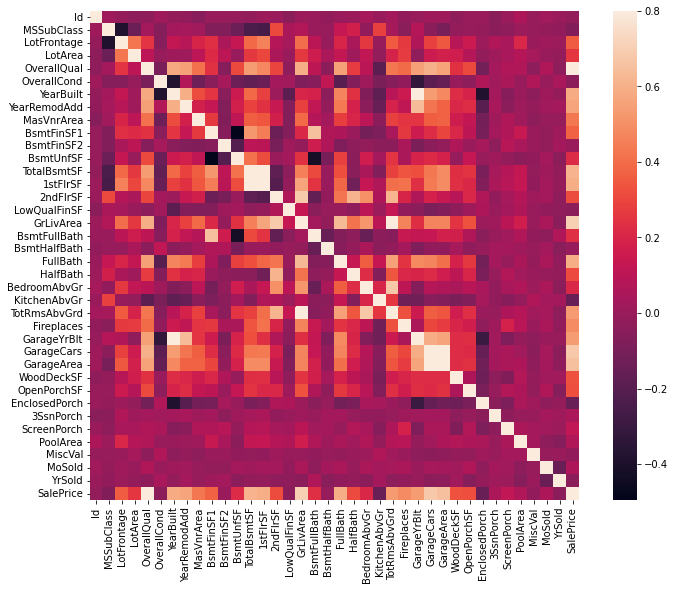

In [ ]:
# Análisis de correlación

corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

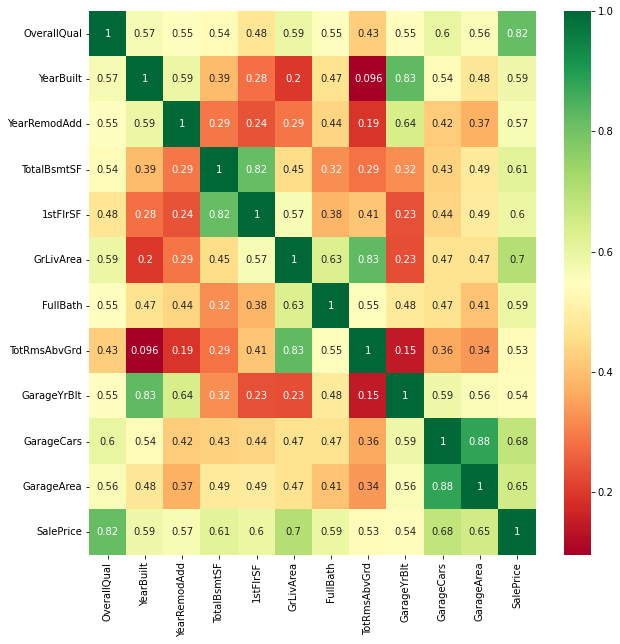

In [ ]:
corr = train.corr()
highest_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[highest_corr_features].corr(),annot=True,cmap="RdYlGn")

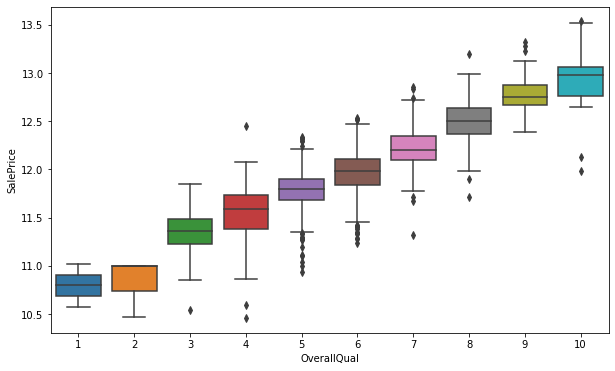

In [ ]:
# Graficando correlaciones entre variable dependeiente 'SalePrice' y las de más alto valor de relación - 'OverallQual', 'GrlivArea'.

plt.figure(figsize=(10,6))
sns.boxplot(data=train,x='OverallQual',y='SalePrice')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


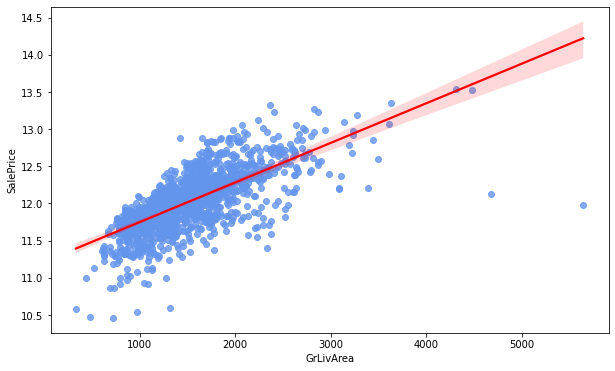

In [ ]:

plt.figure(figsize=(10,6))
x =train['GrLivArea']
y= train['SalePrice']
sns.regplot(x , y, color='cornflowerblue', line_kws = {'color': 'red'})


plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


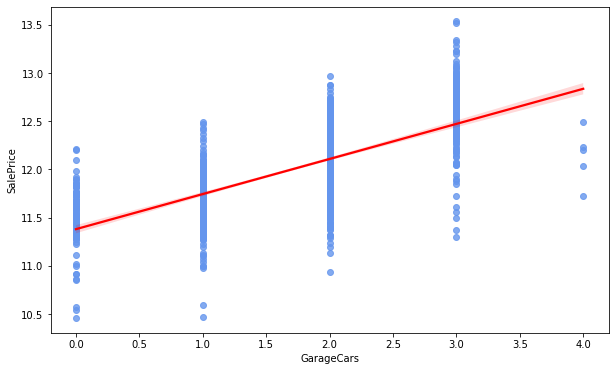

In [ ]:
plt.figure(figsize=(10,6))
x =train['GarageCars']
y= train['SalePrice']
sns.regplot(x , y, color='cornflowerblue', line_kws = {'color': 'red'})


plt.show()

+ **Concatenando las dos bases para preprocesamiento**

In [ ]:
# Concateanando base 'train' y 'test' para realizar preprocesameinto total y luego realizar la separación posterior al análisis.

y_train = train['SalePrice']
test_ids = test['Id']

train = train.drop(['Id', 'SalePrice'], axis=1)
test = test.drop(['Id'], axis=1)

all_data = pd.concat([train, test], axis=0).reset_index(drop=True)

In [ ]:
all_data.shape

(2919, 79)

In [ ]:
all_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


+ **Exploración y tratamiento a valores nulos de la data**

In [ ]:
# Observando valores nulos.

total = all_data.isnull().sum().sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
percent = round(all_data.isnull().sum().sort_values(ascending = False)/len(train)*100,2)[round(all_data.isnull().sum().sort_values(ascending = False)/len(all_data)*100,2) != 0]
data_type = all_data.dtypes.sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
pd.concat([total, percent, data_type], axis=1, keys=['Total','Percent','Type'])

,Total,Percent,Type
PoolQC,2909,199.25,object
MiscFeature,2814,192.74,object
Alley,2721,186.37,object
Fence,2348,160.82,object
FireplaceQu,1420,97.26,object
LotFrontage,486,33.29,float64
GarageYrBlt,159,10.89,float64
GarageFinish,159,10.89,object
GarageQual,159,10.89,object
GarageCond,159,10.89,object


In [ ]:
# Según el documento que describe las variables, hay categóricas que poseen la opción 'None' y por lo tanto no son de por sí
# valores nulos como lo indica la gráfica anterior, sino que, son valores donde no hay existencias y,
# en vez de borrar, se cambiarán los perdidos por esta opción.
# Para los otros casos de categóricas se reemplazarán los perdidos por la moda.
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
  all_data[column] = all_data[column].fillna("None")

for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
  all_data[column] = all_data[column].fillna(all_data[column].mode()[0])

In [ ]:
# Observando nuevamente valores nulos.

total = all_data.isnull().sum().sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
percent = round(all_data.isnull().sum().sort_values(ascending = False)/len(train)*100,2)[round(all_data.isnull().sum().sort_values(ascending = False)/len(all_data)*100,2) != 0]
data_type = all_data.dtypes.sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
pd.concat([total, percent, data_type], axis=1, keys=['Total','Percent','Type'])

,Total,Percent,Type
LotFrontage,486,33.29,float64
GarageYrBlt,159,10.89,float64
MasVnrArea,23,1.58,float64
BsmtFullBath,2,0.14,float64
BsmtHalfBath,2,0.14,float64
TotalBsmtSF,1,0.07,float64
BsmtUnfSF,1,0.07,float64
BsmtFinSF2,1,0.07,float64
GarageCars,1,0.07,float64
BsmtFinSF1,1,0.07,float64


In [ ]:
# Imputación con función fillna por la media en el resto de variables numéricas que quedan con valores nulos.
all_data.fillna(all_data.mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [ ]:
# Observando última vez valores nulos.

total = all_data.isnull().sum().sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
percent = round(all_data.isnull().sum().sort_values(ascending = False)/len(train)*100,2)[round(all_data.isnull().sum().sort_values(ascending = False)/len(all_data)*100,2) != 0]
data_type = all_data.dtypes.sort_values(ascending = False)[all_data.isnull().sum().sort_values(ascending = False) != 0]
pd.concat([total, percent, data_type], axis=1, keys=['Total','Percent','Type'])

,Total,Percent,Type


+ **Normalidad de las variables numéricas**

In [ ]:
# Preprando datos numéricos para revisión de normalidad de distribución.

numerical_feats = all_data.dtypes[all_data.dtypes != "object"].index
print("Cantidad de variables numéricas: ", len(numerical_feats))
print('+'*100)
print(all_data[numerical_feats].columns)

Cantidad de variables numéricas:  36
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [ ]:
# Normalizando la asimetría de distribución de las variables numéricas (al igual como lo hecho con la variable dependiendte 'SalePrice' al comienzo).

skewed_feats = all_data[numerical_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.5]
high_skew

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146034
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931343
MasVnrArea        2.611549
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.645574
1stFlrSF          1.469604
BsmtFinSF1        1.425233
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.162484
BsmtUnfSF         0.919508
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.623955
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64

In [ ]:
# Aplicando función logarítmica a los datos con skew mayor a 0.5

for feature in high_skew.index:
    all_data[feature] = np.log1p(all_data[feature])

+ **Variables procesadas**

In [ ]:
# Creado nuevas variables.

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] # Total metros cuadrados (sótano + primer piso + segundo piso).

all_data['TotalBathrooms'] = (all_data['FullBath'] + (all_data['HalfBath'])
                          + all_data['BsmtFullBath'] + (all_data['BsmtHalfBath'])) # Total de baños en la casa.


In [ ]:
all_data.shape

(2919, 81)

In [ ]:
# Convirtiendo variables categóricas a dummies.

all_data = pd.get_dummies(all_data)
all_data.shape

(2919, 304)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Columns: 304 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(32), int64(6), uint8(266)
memory usage: 1.6 MB


In [ ]:
all_data2 = all_data.copy()

In [ ]:
all_data2.shape

(2919, 304)

In [ ]:
train.index.max()

1459

+ **Cortando la base de datos nuevamente**

In [ ]:
train_final = all_data.loc[:train.index.max(), :].copy()
test_final = all_data.loc[train.index.max()+1:, :].reset_index(drop=True).copy()

In [ ]:
train_final.shape, test_final.shape , y_train.shape

((1460, 304), (1459, 304), (1460,))

In [ ]:
# Creando función de puntaje

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_predict):
    return np.sqrt(mean_squared_error(y, y_predict))


# build our model scoring function
def cv_rmse(model, X=train_final):
    rmse = np.sqrt(-cross_val_score(model, train_final, y_train,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

+ **Aplicando modelo XGBoost**

In [ ]:
import xgboost as XGB

the_model = XGB.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
the_model.fit(train_final, y_train)

[08:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
             min_child_weight=1.7817, n_estimators=2200, nthread=-1,
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             subsample=0.5213)

In [ ]:
y_predict = np.floor(np.expm1(the_model.predict(test_final)))
y_predict

array([126627., 162856., 183503., ..., 158748., 118413., 232064.],
      dtype=float32)

In [ ]:
y_predict.shape

(1459,)

In [ ]:
score =cv_rmse(the_model)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

[10:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:41:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:41:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:41:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:42:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
r2_score(y_train, the_model.predict(train_final))

0.9610424086686283

+ **Guardando resultados en archivo**

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ids
sub['SalePrice'] = y_predict
sub.head()

,Id,SalePrice
0,1461,126627.0
1,1462,162856.0
2,1463,183503.0
3,1464,193805.0
4,1465,190529.0


In [ ]:
sub.to_csv('cr_submission.csv',index=False)


Para cumplir con el objetivo de la competencia en Kaggle, elegí utilizar el modelo XGBoost. Después de cargar los resultados en la plataforma, obtuve la posición número 456 de 4339 participantes. El código que utilicé contribuyó al 11% del total.